In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime, timedelta

import pymongo 
from pymongo import MongoClient

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Prepara leitura do banco

In [2]:
# Read files
client = MongoClient()
db = client.cmp263
collection = db.measures
coll_measures_ts = db.measures_ts
interfaces = db.interfaces
coll_measures = db.measure_delta

# Consulta no banco

In [3]:
start = datetime(2021, 3, 25, 0, 0, 0)
#start = datetime(2021, 3, 25, 0, 0, 0)

dfI  = pd.DataFrame(list(interfaces.find({"ifInOctets": {"$gt": 0}})))
ifIn = list(dfI['name'])

In [183]:
dt = pd.DataFrame(list(coll_measures.find({
    "dt": {"$gte" : start},
    "interface_id": {"$in": [141]}   # Gigabit2/4
    # "interface_id": {"$in": [143]}   # VLAN179
    #"interface_id": {"$in": [143]}   # VLAN163
    #"interface_id": {"$in": [143, 204]}   # VLAN179 e VLAN 163
    #"interface_id": {"$in": [141, 143]} # Gigabit2/4 e VLAN179
    #"interface_id": {"$in": [143, 204, 202, 134, 128, 158, 117, 161, 132, 131, 126]}   # VLAN179 e VLAN 163
}, {"hrProcessorLoad": 1, "ifInOctets": 1, "ifOutOctets": 1, "ts": 1, "dt": 1, "_id": 0}).sort("ts", 1)))
dt.head()

hrProcessorLoad  ifInOctets  ifOutOctets             ts  \
0               27           0            0  1616630402423   
1               20       21917        58070  1616630702182   
2               20       30452        64630  1616631002098   
3               19       22626        58608  1616631302132   
4               19       29590        64244  1616631602245   

                       dt  
0 2021-03-25 00:00:02.423  
1 2021-03-25 00:05:02.182  
2 2021-03-25 00:10:02.098  
3 2021-03-25 00:15:02.132  
4 2021-03-25 00:20:02.245

In [184]:
#dt = dt[1::12]
date_time   = pd.to_datetime(dt.pop('dt'), format='%Y-%m-%d %H:%M.%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
dt.pop('ts')
dt.head()

hrProcessorLoad  ifInOctets  ifOutOctets
0               27           0            0
1               20       21917        58070
2               20       30452        64630
3               19       22626        58608
4               19       29590        64244

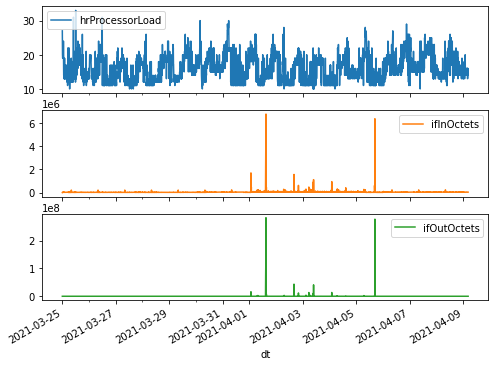

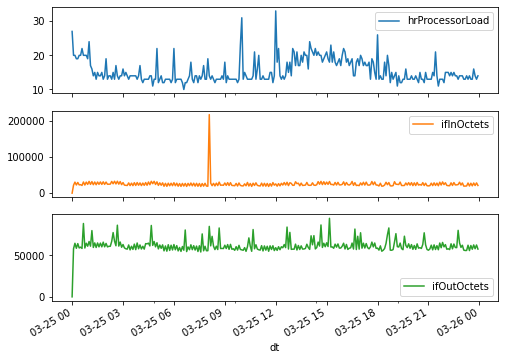

In [185]:
plot_cols = ['hrProcessorLoad', 'ifInOctets','ifOutOctets']
plot_features = dt[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dt[plot_cols][:288]
plot_features.index = date_time[:288]
_ = plot_features.plot(subplots=True)

In [186]:
dt.describe().transpose()

count           mean           std   min      25%      50%  \
hrProcessorLoad  4375.0      15.761600  3.653811e+00  10.0     13.0     15.0   
ifInOctets       4375.0   48630.175771  1.777757e+05   0.0  24934.0  36731.0   
ifOutOctets      4375.0  368518.312686  7.077475e+06   0.0  58366.0  62484.0   

                     75%          max  
hrProcessorLoad     18.0         33.0  
ifInOctets       47731.5    6765281.0  
ifOutOctets      90218.5  282343888.0

Text(0, 0.5, 'ifInOctets')

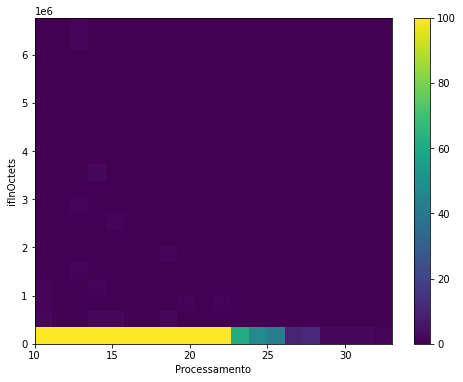

In [187]:
plt.hist2d(dt['hrProcessorLoad'], dt['ifInOctets'], bins=(20, 20), vmax=100)
plt.colorbar()
plt.xlabel('Processamento')
plt.ylabel('ifInOctets')

Text(0, 0.5, 'ifOutOctets')

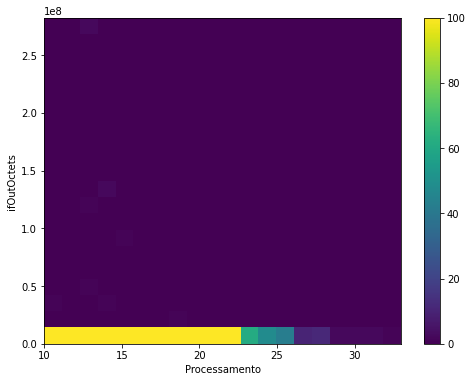

In [188]:
plt.hist2d(dt['hrProcessorLoad'], dt['ifOutOctets'], bins=(20, 20), vmax=100)
plt.colorbar()
plt.xlabel('Processamento')
plt.ylabel('ifOutOctets')

Text(0.5, 1.0, 'Time of day signal')

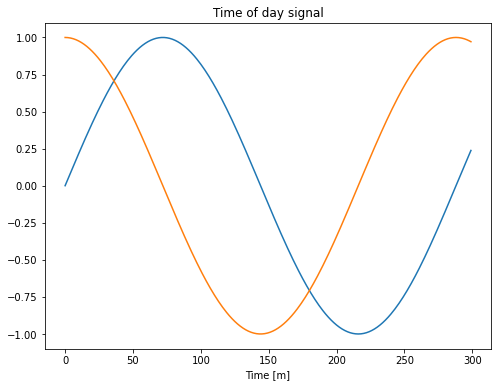

In [189]:
hour = 60*60
day  = 24*60*60
week = day * 7
month = day * 30
year = (365.2425)*day

dt['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
dt['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
dt['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dt['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dt['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
dt['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
#dt['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
#dt['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


plt.plot(np.array(dt['Day sin'])[:300])
plt.plot(np.array(dt['Day cos'])[:300])
plt.xlabel('Time [m]')
plt.title('Time of day signal')

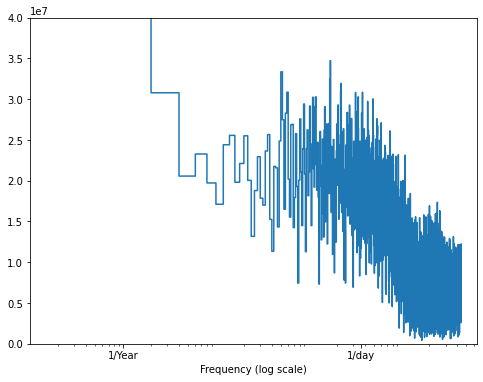

In [190]:
fft = tf.signal.rfft(dt['ifInOctets'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(dt['ifInOctets'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Divisão de dados
Usaremos uma divisão (75%, 15%, 10%) para os conjuntos de treinamento, validação e teste. Observe que os dados não estão sendo embaralhados aleatoriamente antes da divisão. Isso é por duas razões.

In [191]:
column_indices = {name: i for i, name in enumerate(dt.columns)}

n = len(dt)
train_df = dt[0:int(n*0.75)]
val_df   = dt[int(n*0.75):int(n*0.9)]
test_df  = dt[int(n*0.9):]

num_features = dt.shape[1]

# Normalização dos dados

In [192]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

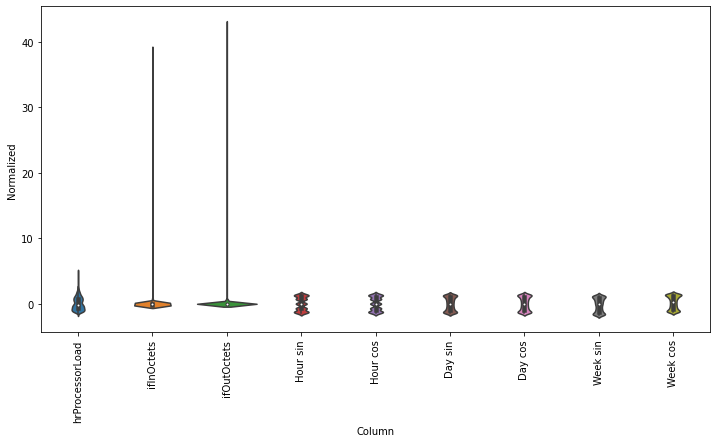

In [193]:
df_std = (dt - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

df_std

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dt.keys(), rotation=90)

# Janela de dados

Define um conjunto de dados para fazer previsões futura.
Será utilizado para demonstração dados de 24h para fazer previsões da próxima hora. 

In [194]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [195]:
# Janela de dados para previsão de 24h
w1 = WindowGenerator(input_width=288, label_width=12, shift=288, label_columns=['hrProcessorLoad','ifInOctets', 'ifOutOctets'])
w1



Total window size: 576
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [196]:
# Proximas 8 horas
w2 = WindowGenerator(input_width=96, label_width=36, shift=1,
                     label_columns=['ifInOctets', 'ifOutOctets', 'hrProcessorLoad'])
w2

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['ifInOctets', 'ifOutOctets', 'hrProcessorLoad']

In [197]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [198]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')



All shapes are: (batch, time, features)
Window shape: (3, 97, 9)
Inputs shape: (3, 96, 9)
labels shape: (3, 36, 3)


In [199]:
w2.example = example_inputs, example_labels

In [200]:
def plot(self, model=None, plot_col='ifInOctets', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(36, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [m]')

WindowGenerator.plot = plot

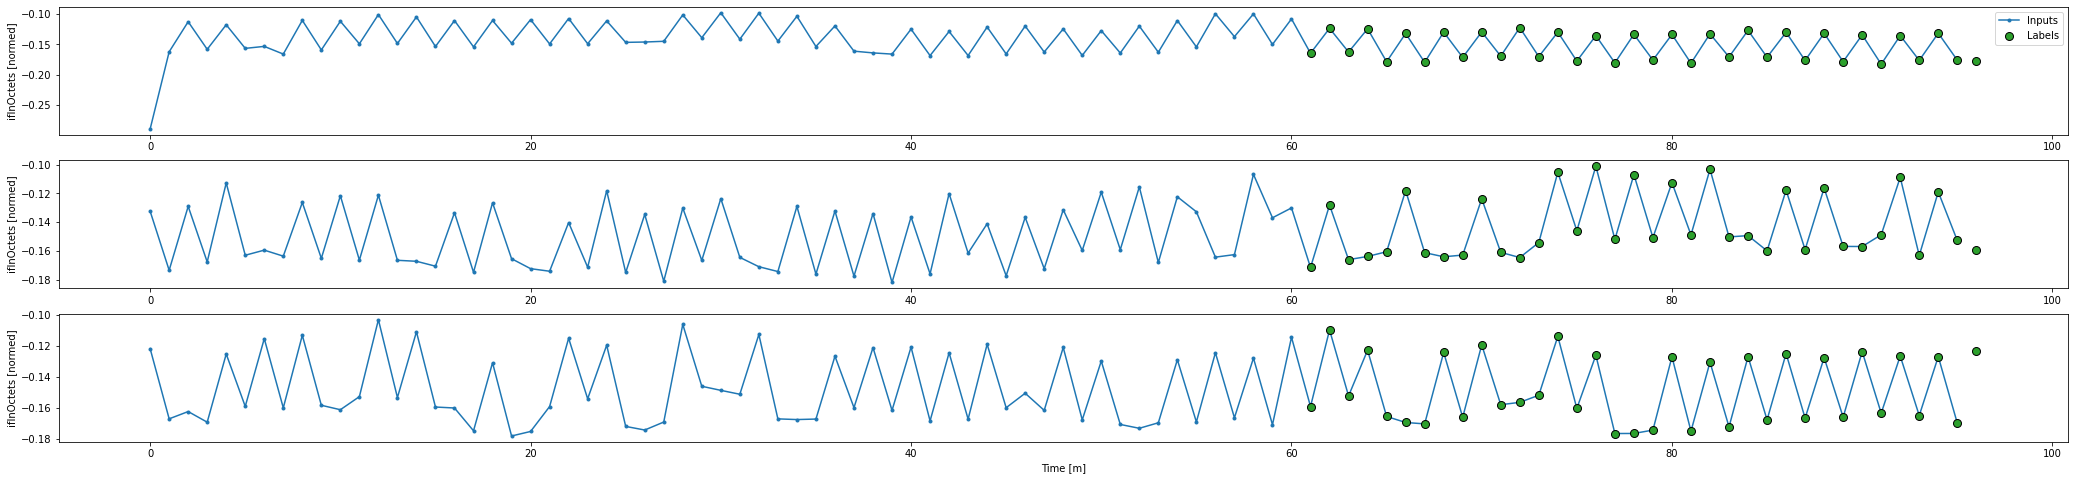

In [201]:
w2.plot()

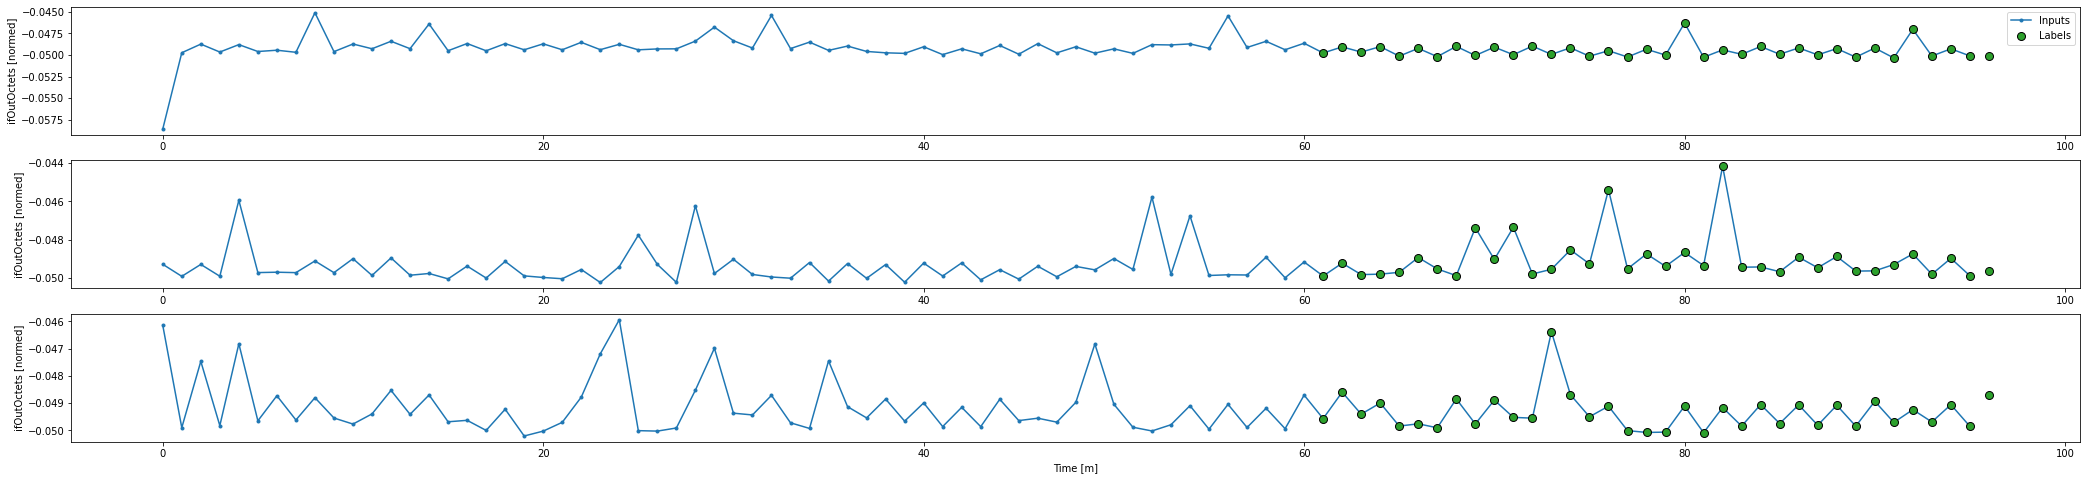

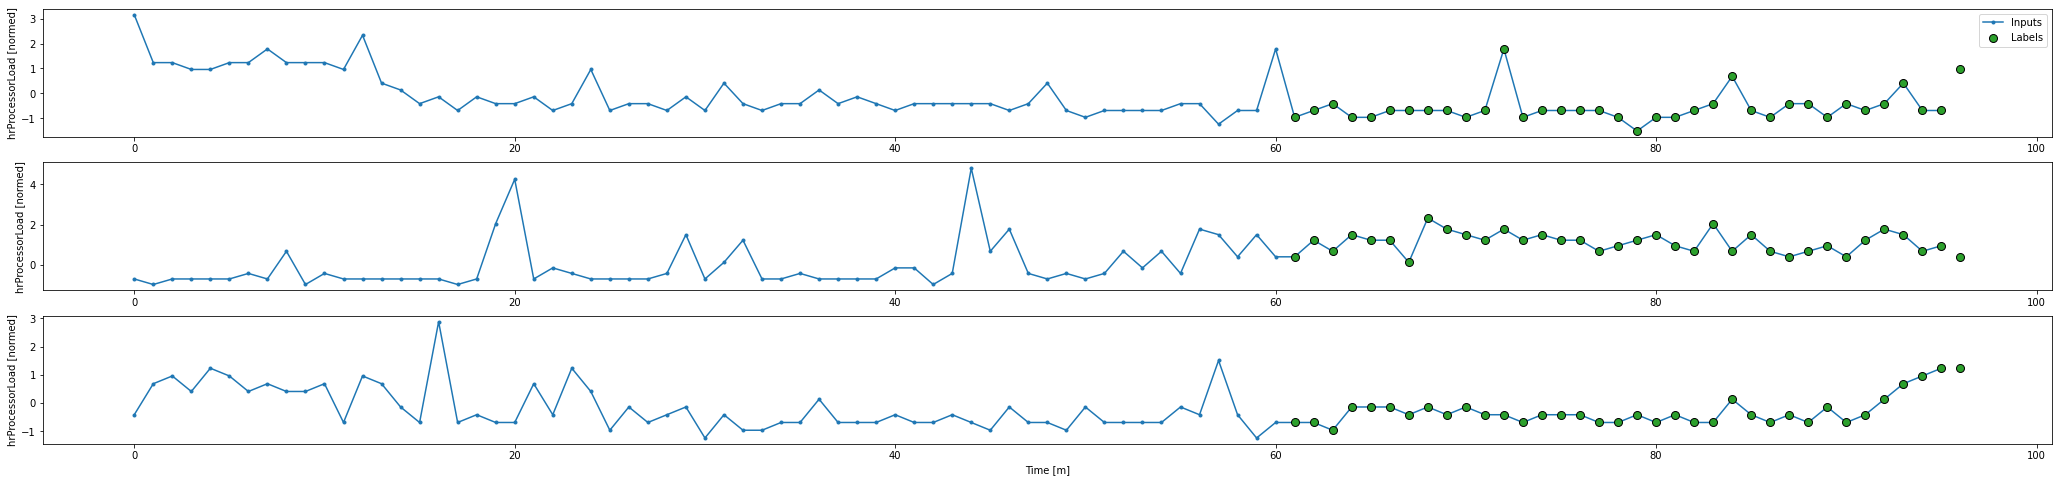

In [202]:
w2.plot(plot_col='ifOutOctets')
w2.plot(plot_col='hrProcessorLoad')

In [203]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [204]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [205]:
w2.train.element_spec

(TensorSpec(shape=(None, 96, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 36, 3), dtype=tf.float32, name=None))

In [206]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 288, 9)
Labels shape (batch, time, features): (128, 12, 3)


In [207]:
single_step_window = WindowGenerator(
    input_width=2, label_width=1, shift=1,
    label_columns=['ifInOctets', 'ifOutOctets', 'hrProcessorLoad'])
single_step_window

Total window size: 3
Input indices: [0 1]
Label indices: [2]
Label column name(s): ['ifInOctets', 'ifOutOctets', 'hrProcessorLoad']

In [208]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 2, 9)
Labels shape (batch, time, features): (128, 1, 3)


# Linha de base

In [209]:
# Linha de base
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [210]:
baseline = Baseline(label_index=column_indices['ifInOctets'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

6/6 [==============================] - 0s 2ms/step - loss: 4.0980 - mean_absolute_error: 0.4240


In [211]:
wide_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['ifInOctets', 'ifOutOctets'])

wide_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['ifInOctets', 'ifOutOctets']

In [212]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 96, 9)
Output shape: (128, 96, 1)


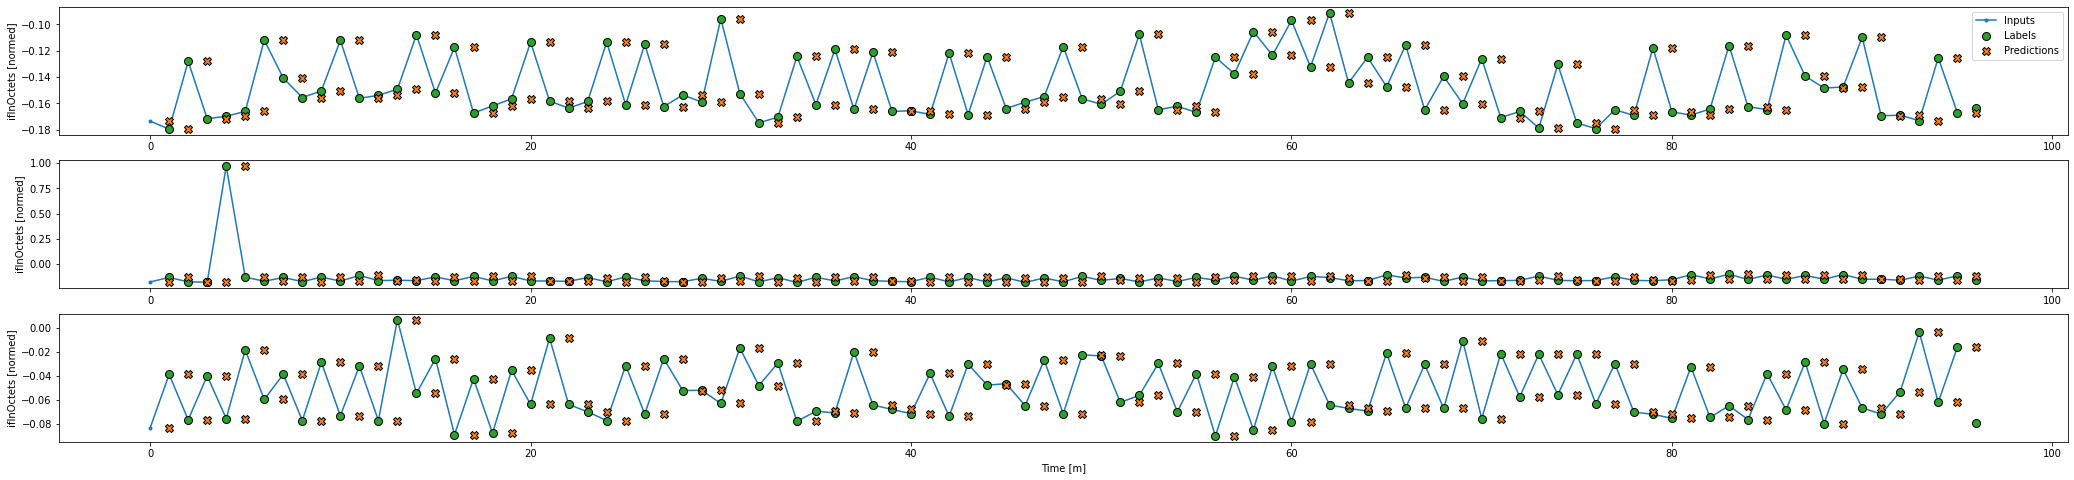

In [213]:
wide_window.plot(baseline)
#wide_window.plot(baseline, plot_col='ifOutOctets')

# Modelo Linear

In [228]:
# Modelo Linear
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=3)
])

In [229]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (128, 2, 9)
Output shape: (128, 2, 3)


In [230]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [231]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
26/26 [==============================] - 1s 10ms/step - loss: 2.6316 - mean_absolute_error: 1.0579 - val_loss: 4.1895 - val_mean_absolute_error: 1.2249
Epoch 2/20
26/26 [==============================] - 0s 6ms/step - loss: 2.4779 - mean_absolute_error: 1.0138 - val_loss: 3.9967 - val_mean_absolute_error: 1.1759
Epoch 3/20
26/26 [==============================] - 0s 6ms/step - loss: 2.3312 - mean_absolute_error: 0.9716 - val_loss: 3.8215 - val_mean_absolute_error: 1.1285
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 2.1970 - mean_absolute_error: 0.9313 - val_loss: 3.6677 - val_mean_absolute_error: 1.0837
Epoch 5/20
26/26 [==============================] - 0s 6ms/step - loss: 2.0746 - mean_absolute_error: 0.8924 - val_loss: 3.5064 - val_mean_absolute_error: 1.0382
Epoch 6/20
26/26 [==============================] - 0s 6ms/step - loss: 1.9583 - mean_absolute_error: 0.8553 - val_loss: 3.3690 - val_mean_absolute_error: 0.9962
Epoch 7/20
26/26 [=========

In [232]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 96, 9)
Output shape: (128, 96, 1)


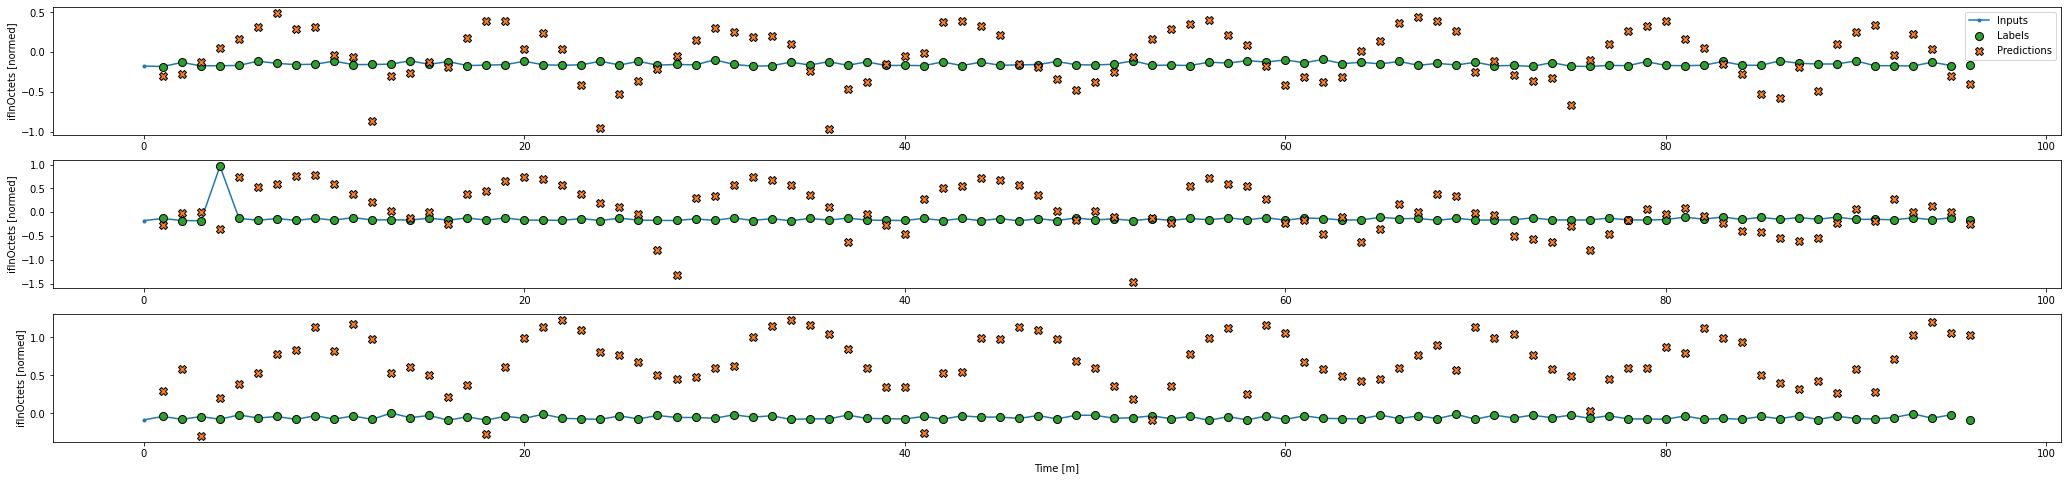

In [233]:
wide_window.plot(linear)

# Pesos das entradas

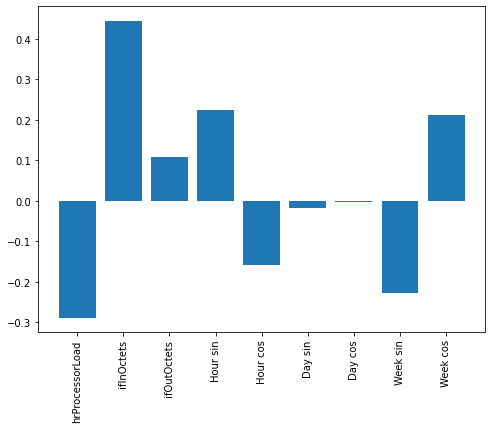

In [234]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Denso

Antes de aplicar modelos que realmente operam em várias etapas de tempo, vale a pena verificar o desempenho de modelos de etapa de entrada única mais profundos, mais poderosos.

Aqui está um modelo semelhante ao modelo linear , exceto que empilha várias camadas Dense entre a entrada e a saída:

Epoch 1/20
26/26 [==============================] - 1s 13ms/step - loss: 0.9814 - mean_absolute_error: 0.4025 - val_loss: 2.1020 - val_mean_absolute_error: 0.4607
Epoch 2/20
26/26 [==============================] - 0s 6ms/step - loss: 0.8176 - mean_absolute_error: 0.4055 - val_loss: 2.2568 - val_mean_absolute_error: 0.4615
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 2.2817 - mean_absolute_error: 0.4667


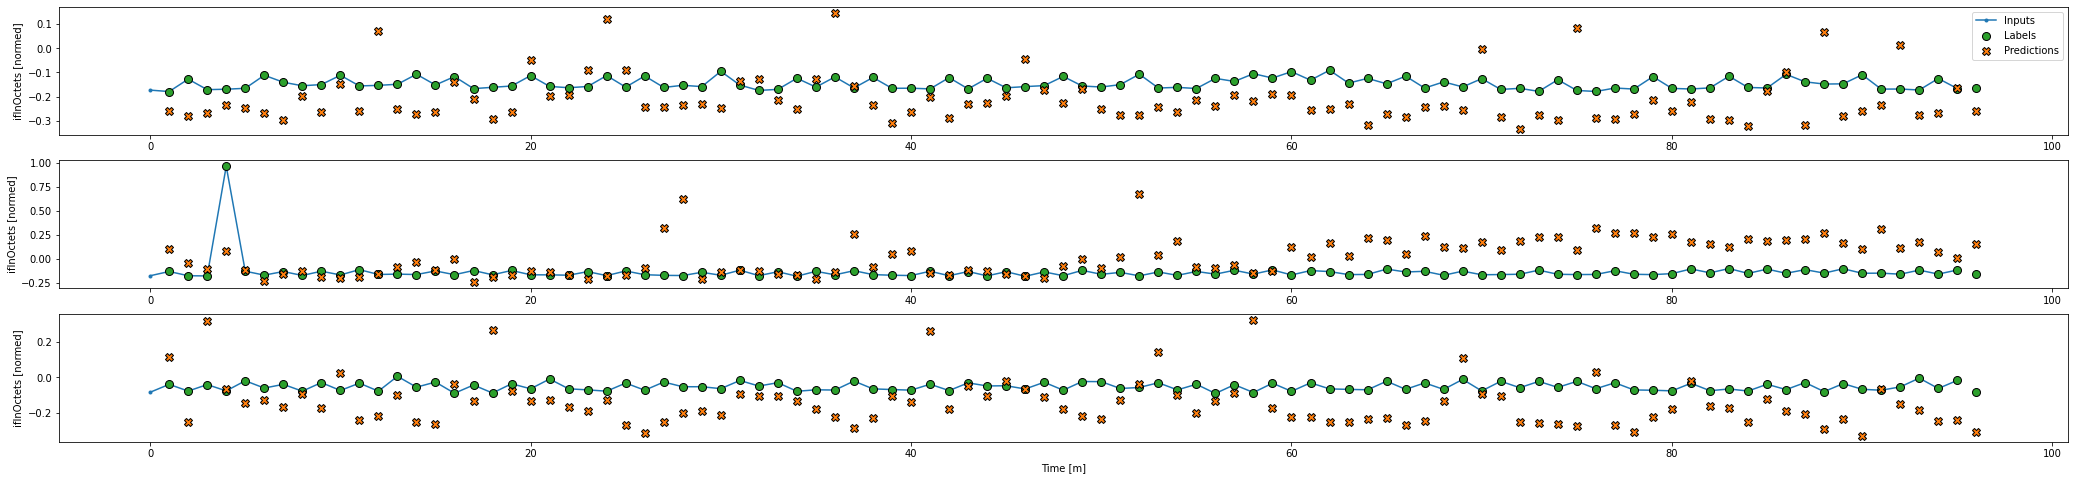

In [235]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

wide_window.plot(dense)

Epoch 1/20
26/26 [==============================] - 1s 14ms/step - loss: 0.8641 - mean_absolute_error: 0.4043 - val_loss: 2.3378 - val_mean_absolute_error: 0.4398
Epoch 2/20
26/26 [==============================] - 0s 6ms/step - loss: 0.7905 - mean_absolute_error: 0.4041 - val_loss: 2.3106 - val_mean_absolute_error: 0.4463
Epoch 3/20
26/26 [==============================] - 0s 6ms/step - loss: 0.7861 - mean_absolute_error: 0.4063 - val_loss: 2.3079 - val_mean_absolute_error: 0.4593
Epoch 4/20
26/26 [==============================] - 0s 6ms/step - loss: 0.7966 - mean_absolute_error: 0.4082 - val_loss: 2.2426 - val_mean_absolute_error: 0.4478
Epoch 5/20
26/26 [==============================] - 0s 6ms/step - loss: 0.7763 - mean_absolute_error: 0.4069 - val_loss: 2.3035 - val_mean_absolute_error: 0.4555
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 2.5000 - mean_absolute_error: 0.4437
Wall time: 2.84 s


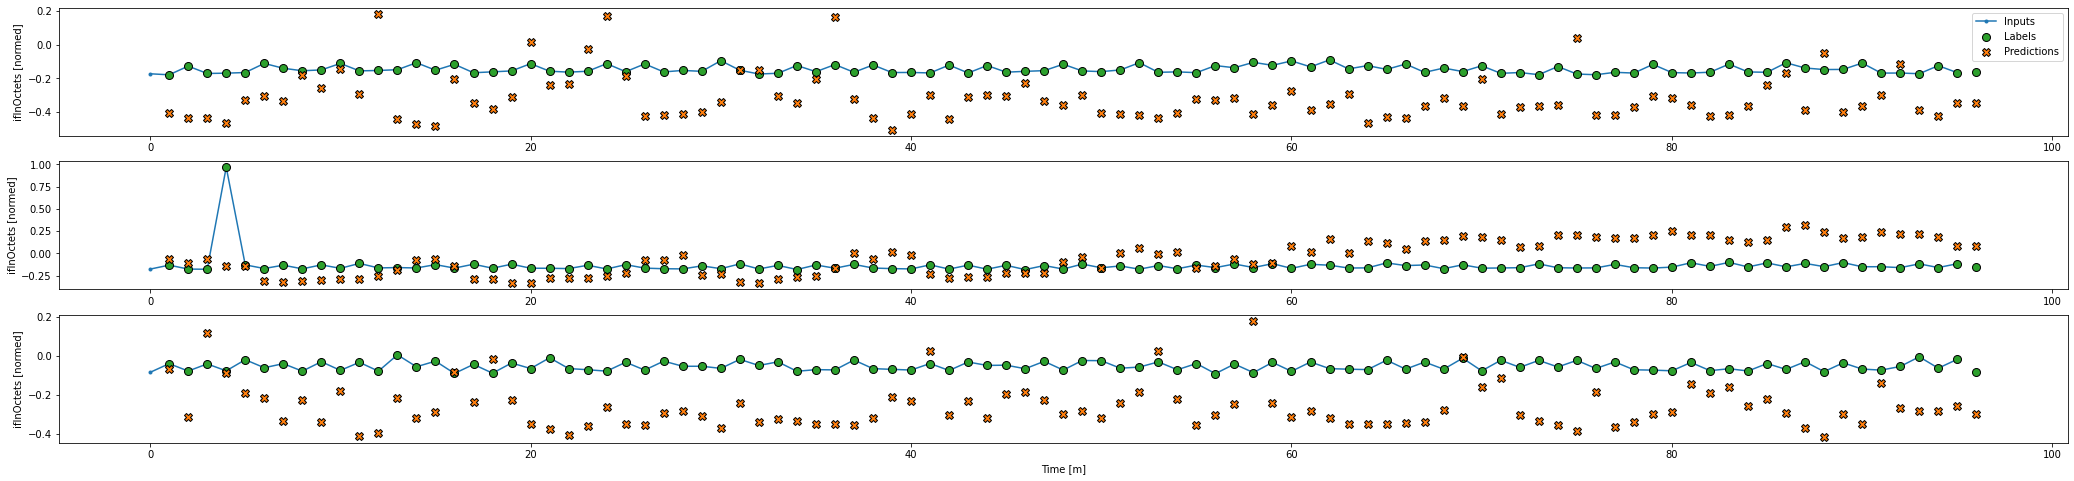

In [236]:
%%time
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

wide_window.plot(dense)

# Multi-step densa

Um modelo de passo único não tem contexto para os valores atuais de suas entradas. Ele não pode ver como os recursos de entrada estão mudando ao longo do tempo. Para resolver esse problema, o modelo precisa de acesso a várias etapas de tempo ao fazer previsões:

In [251]:
CONV_WIDTH = 3*12
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ifInOctets', 'ifOutOctets', 'hrProcessorLoad'])

conv_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36]
Label column name(s): ['ifInOctets', 'ifOutOctets', 'hrProcessorLoad']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

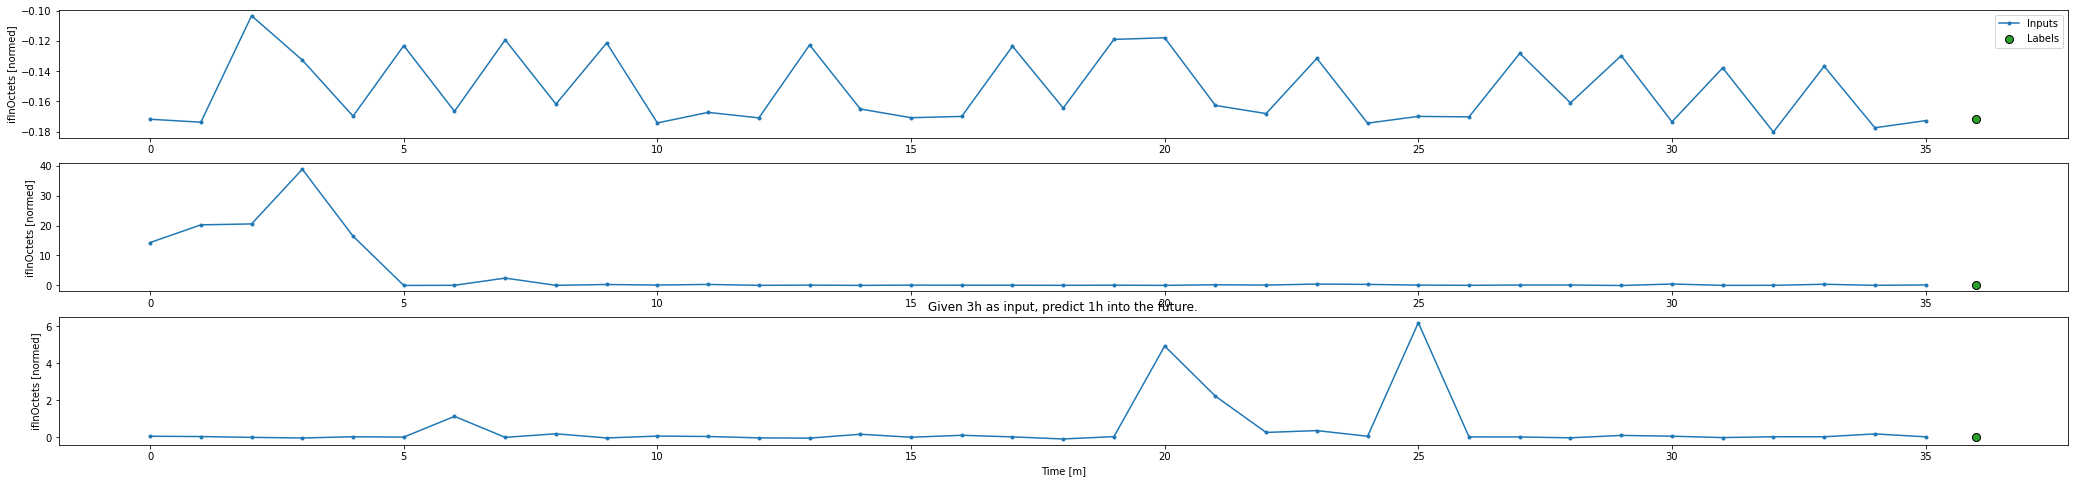

In [252]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [253]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (128, 36, 9)
Output shape: (128, 1, 1)


In [254]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 2.2259 - mean_absolute_error: 0.5153


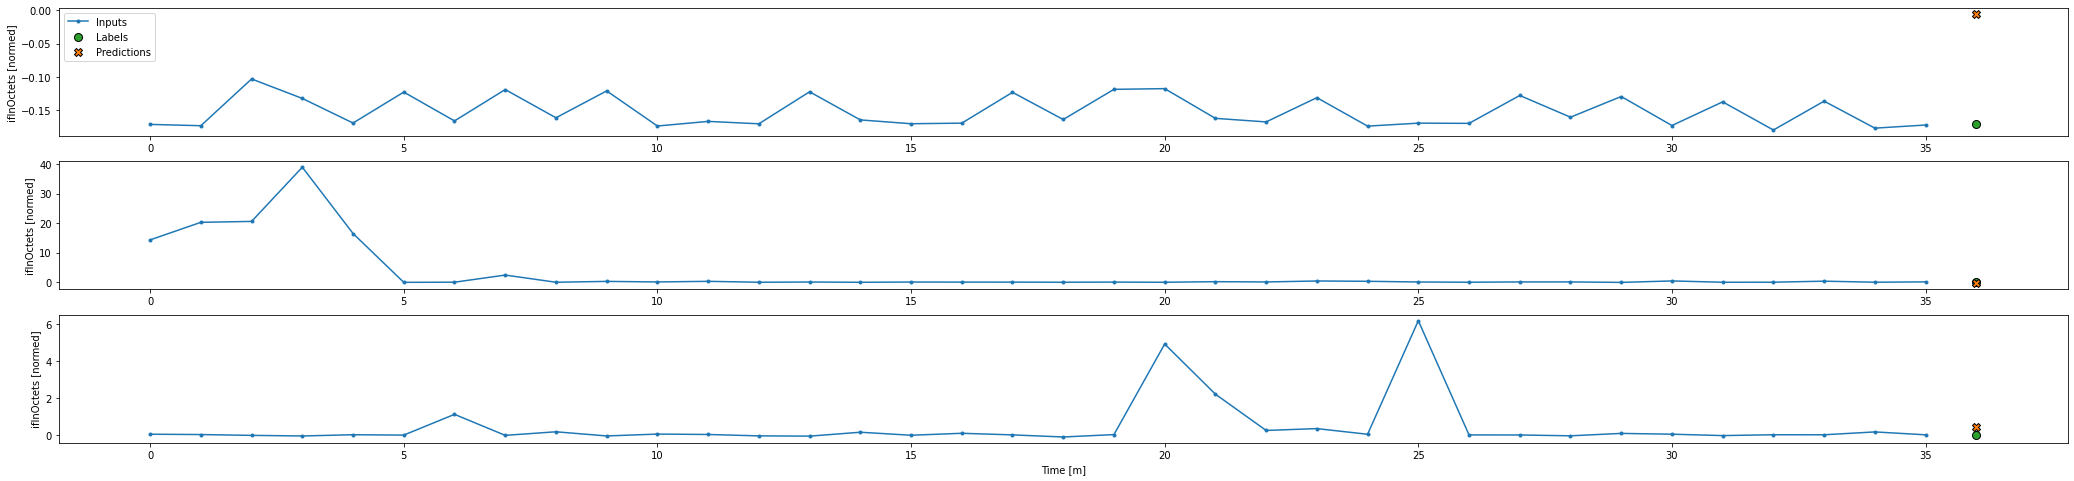

In [255]:
conv_window.plot(multi_step_dense)

In [256]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (128, 96, 9)

ValueError:Input 0 of layer dense_55 is incompatible with the layer: expected axis -1 of input shape to have value 324 but received input with shape (128, 864)


# Rede neural de convolução
Uma camada de convolução ( layers.Conv1D ) também leva várias etapas de tempo como entrada para cada previsão.

In [257]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (128, 36, 9)
Output shape: (128, 1, 1)


In [258]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 1ms/step - loss: 2.1632 - mean_absolute_error: 0.5001


In [259]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (128, 96, 9)
Labels shape: (128, 96, 2)
Output shape: (128, 61, 1)


In [260]:
LABEL_WIDTH = 288
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ifInOctets', 'ifOutOctets', 'hrProcessorLoad'])

wide_conv_window

Total window size: 324
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [261]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (128, 323, 9)
Labels shape: (128, 288, 3)
Output shape: (128, 288, 1)


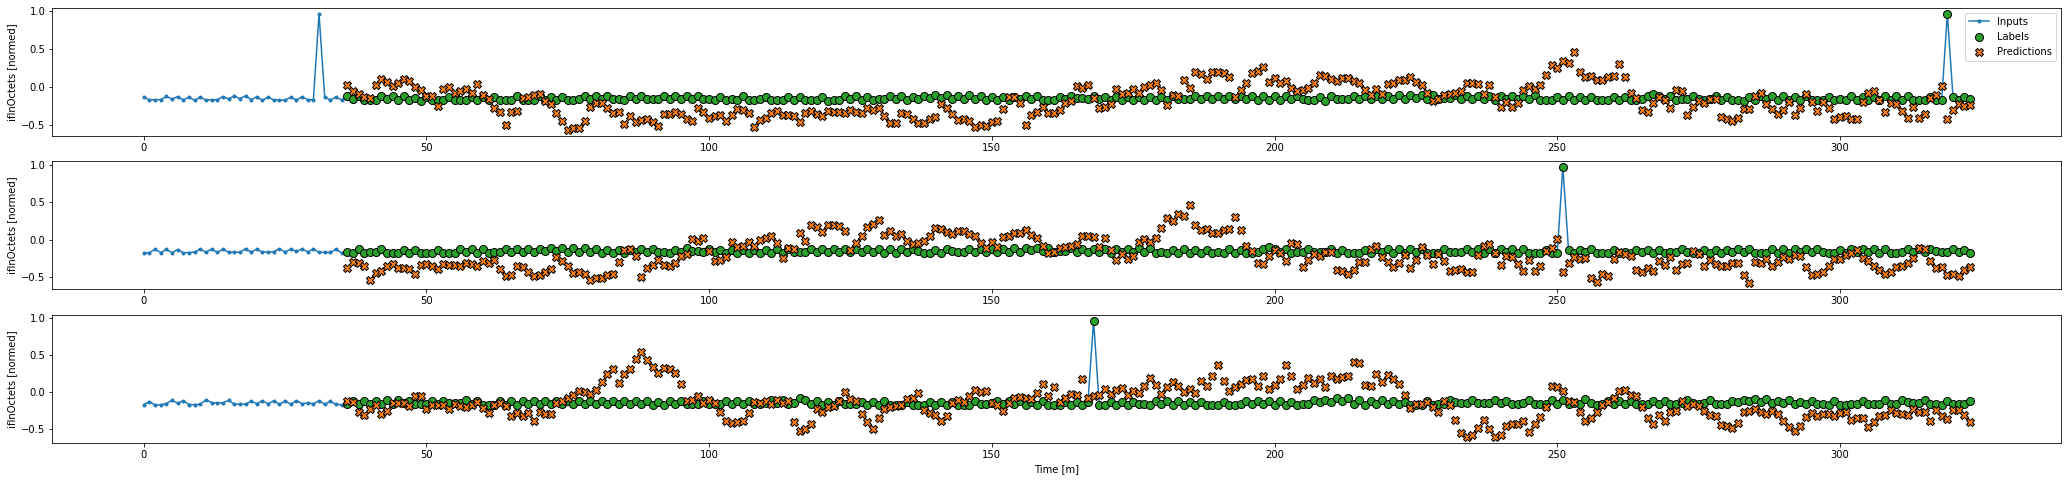

In [262]:
wide_conv_window.plot(conv_model)


# Rede neural recorrente
Uma Rede Neural Recorrente (RNN) é um tipo de rede neural adequada para dados de série temporal. Os RNNs processam uma série temporal passo a passo, mantendo um estado interno passo a passo no tempo.

In [263]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (128, 96, 9)
Output shape: (128, 96, 1)


In [264]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 19ms/step - loss: 2.5508 - mean_absolute_error: 0.1363


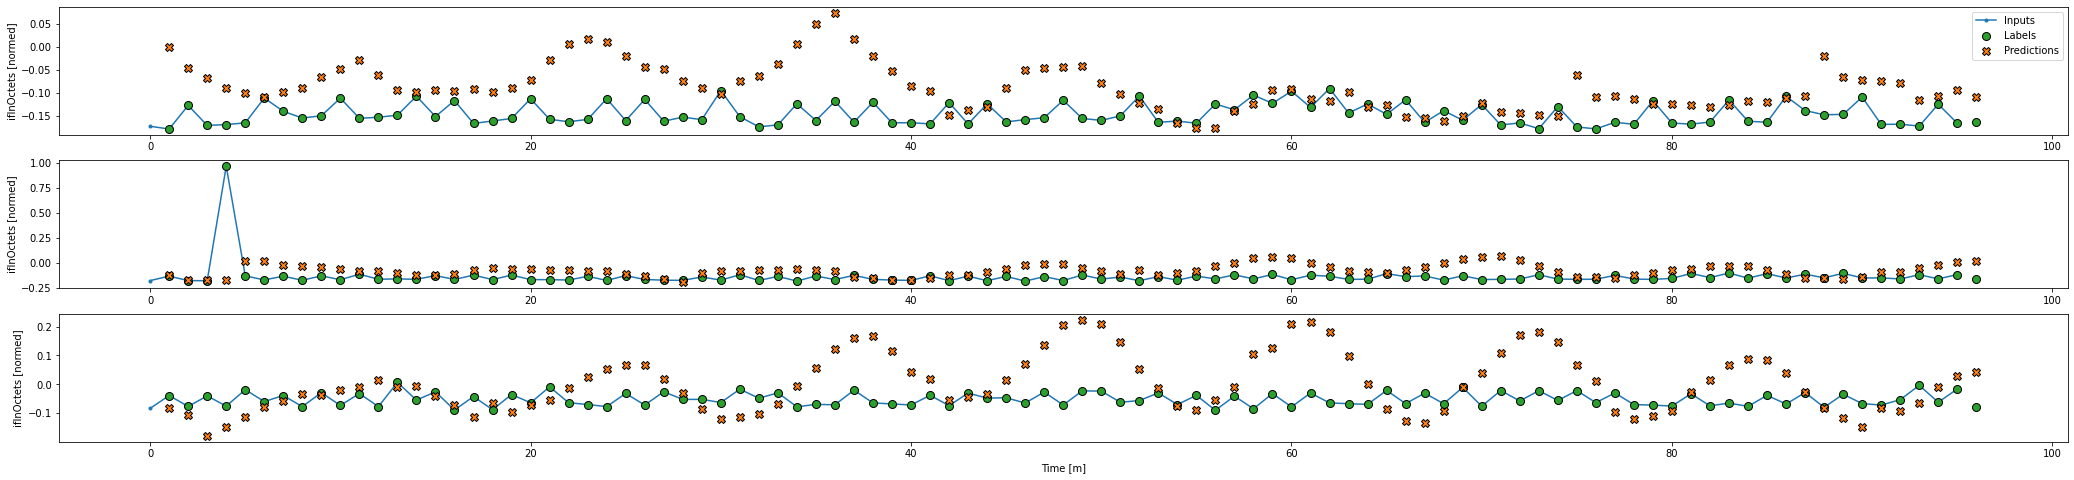

In [265]:
wide_window.plot(lstm_model)
#wide_window.plot(lstm_model)
#wide_window.plot(lstm_model, plot_col='ifOutOctets')
#wide_window.plot(lstm_model, plot_col='hrProcessorLoad')

# Desempenho

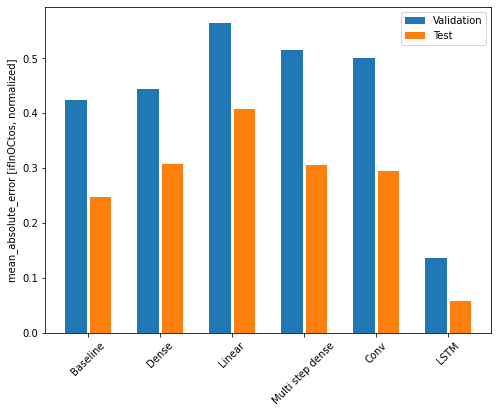

In [266]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [ifInOCtos, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [267]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2476
Dense       : 0.3080
Linear      : 0.4078
Multi step dense: 0.3058
Conv        : 0.2957
LSTM        : 0.0583


#### Modelos de múltiplas saídas

In [268]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=288, label_width=288, shift=11)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 288, 9)
Labels shape (batch, time, features): (128, 288, 9)


# Linha de base

3/3 [==============================] - 0s 4ms/step - loss: 0.7305 - mean_absolute_error: 0.2523


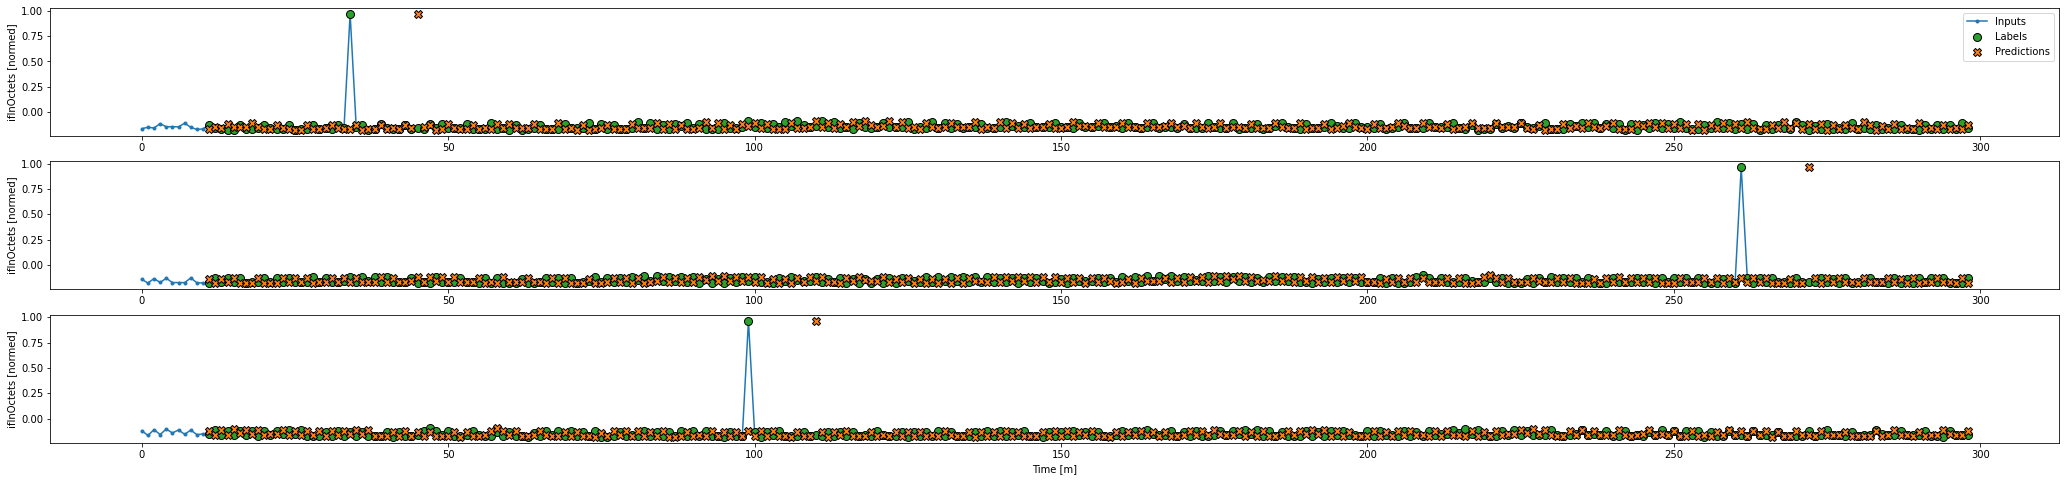

In [269]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)
wide_window.plot(baseline)

# Denso


In [270]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


6/6 [==============================] - 0s 2ms/step - loss: 0.9060 - mean_absolute_error: 0.1697


# RNN

In [272]:
%%time
wide_window = WindowGenerator(
    input_width=288, label_width=288, shift=12)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

3/3 [==============================] - 0s 48ms/step - loss: 0.3625 - mean_absolute_error: 0.1811

Wall time: 37.8 s


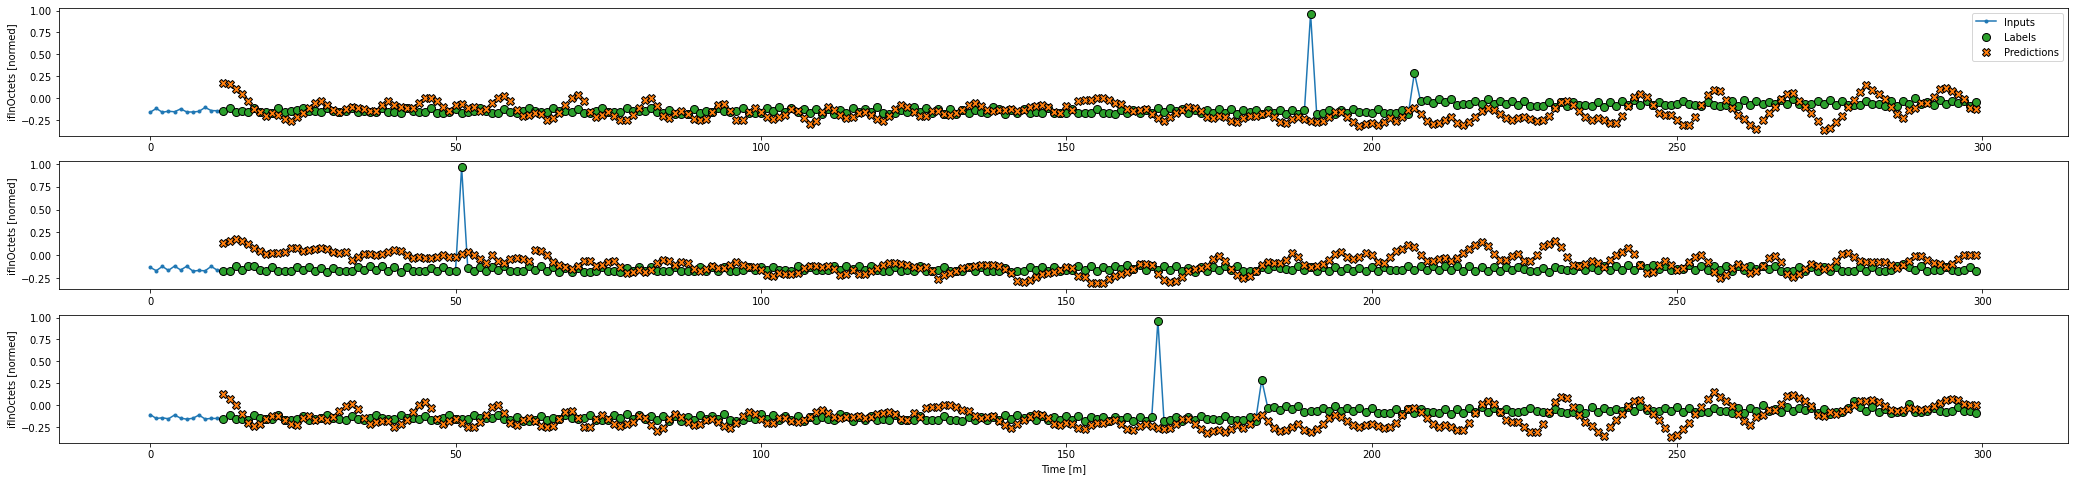

In [273]:
wide_window.plot(lstm_model)

# Rede Residuais

In [274]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

3/3 [==============================] - 0s 51ms/step - loss: 0.5629 - mean_absolute_error: 0.1531



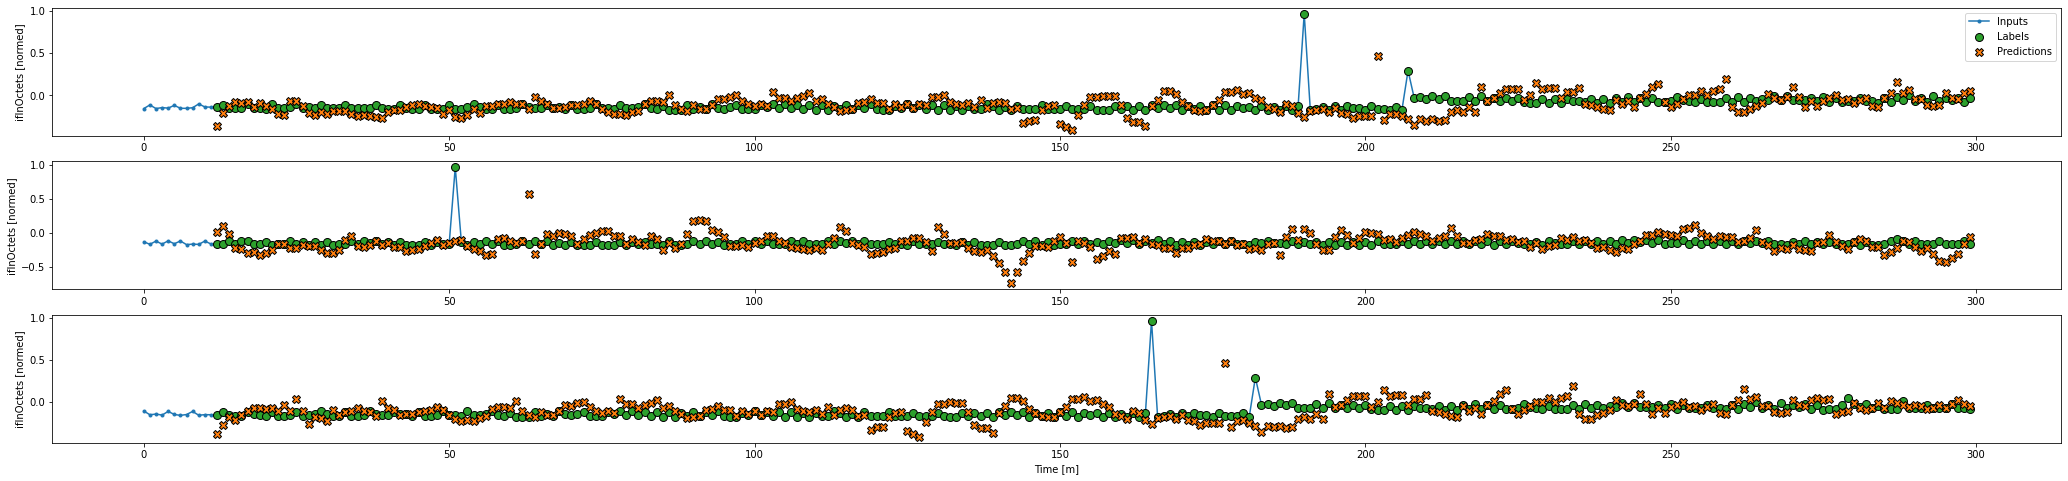

In [275]:
wide_window.plot(residual_lstm)

# Desempenho


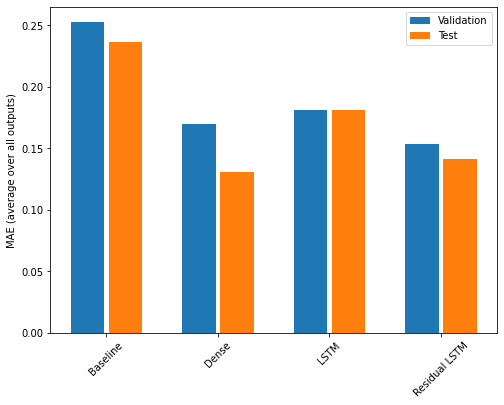

In [276]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [277]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.2365
Dense          : 0.1309
LSTM           : 0.1810
Residual LSTM  : 0.1410


# Modelos multi-etapas

Total window size: 576
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

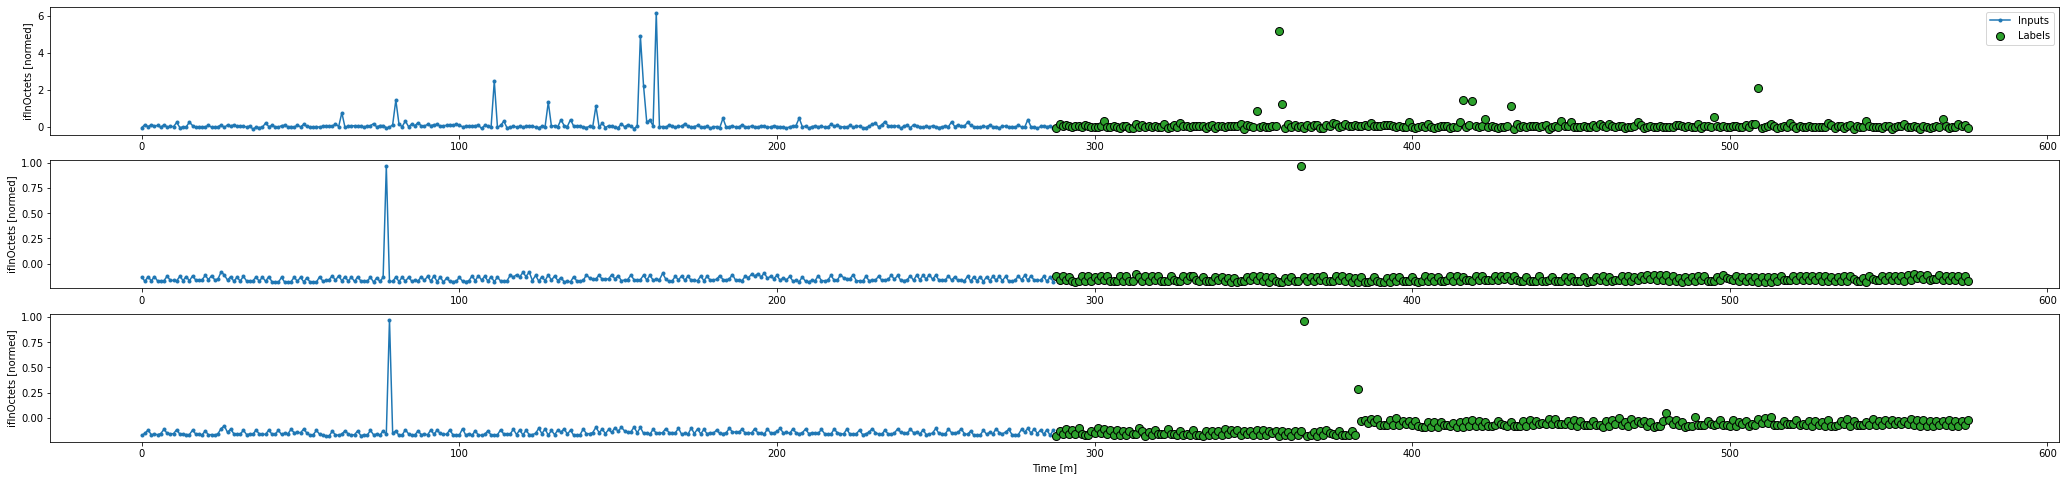

In [278]:
OUT_STEPS = 288
multi_window = WindowGenerator(input_width=288,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Base line

1/1 [==============================] - 0s 163ms/step - loss: 1.1135 - mean_absolute_error: 0.7084


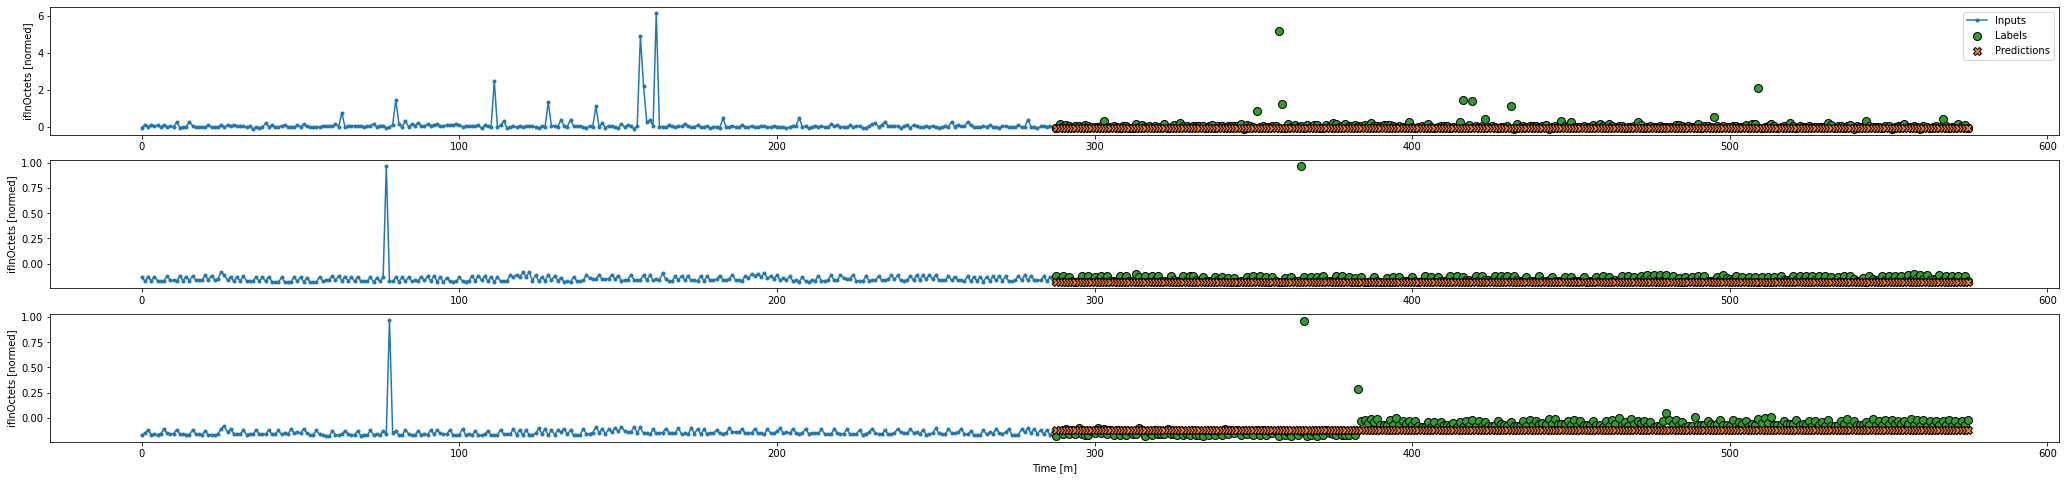

In [279]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 142ms/step - loss: 1.6877 - mean_absolute_error: 0.3588


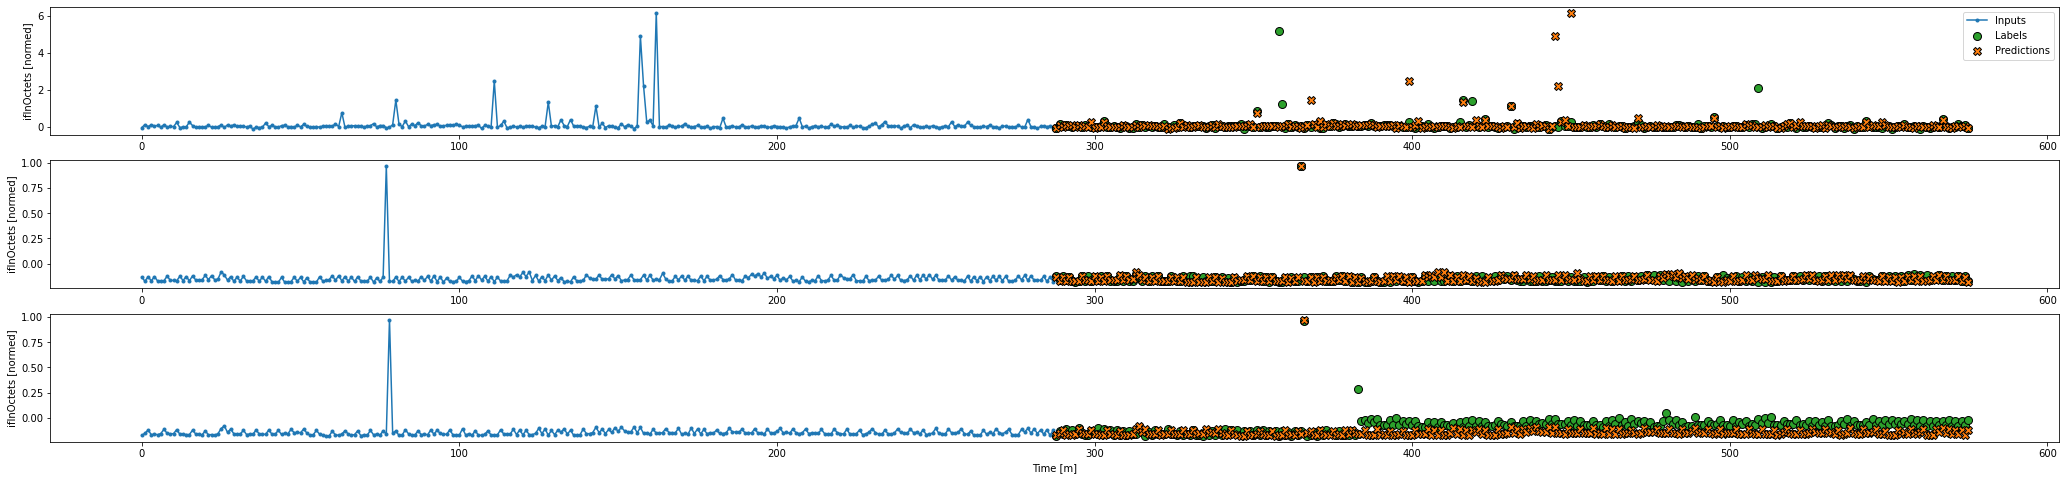

In [280]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Modelos de disparo único
Uma abordagem de alto nível para este problema é usar um modelo "single-shot", onde o modelo faz a predição da sequência inteira em uma única etapa.

1/1 [==============================] - 0s 49ms/step - loss: 0.3233 - mean_absolute_error: 0.4452


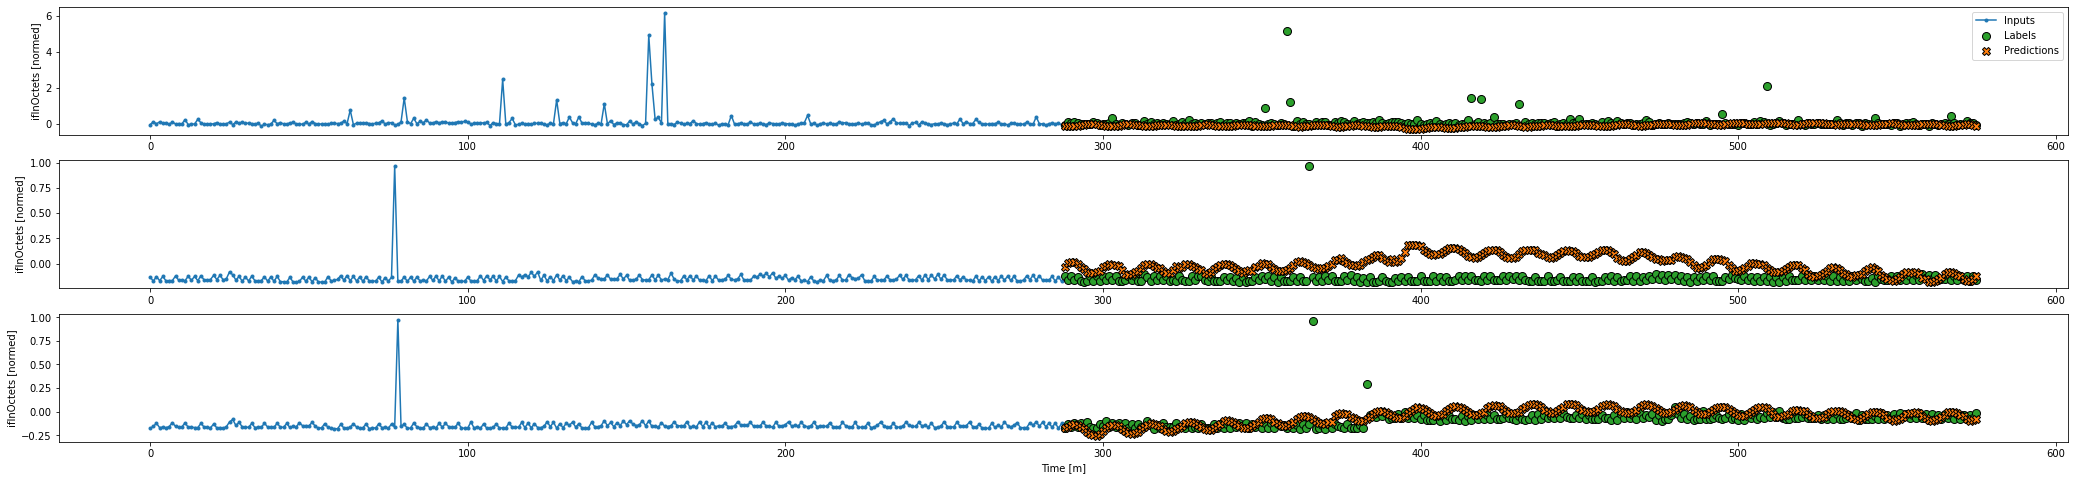

In [281]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Denso

1/1 [==============================] - 0s 54ms/step - loss: 0.1229 - mean_absolute_error: 0.1292


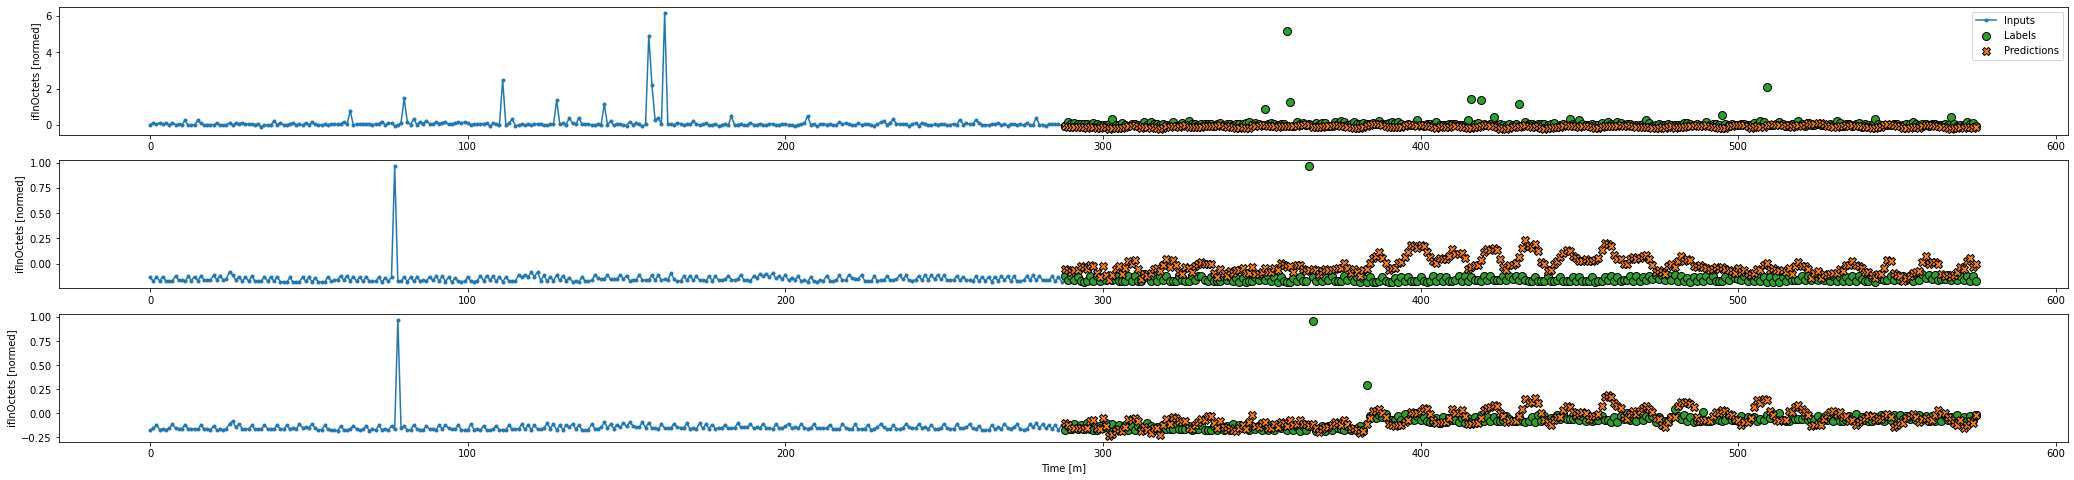

In [282]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# CNN

1/1 [==============================] - 0s 53ms/step - loss: 0.1509 - mean_absolute_error: 0.1478


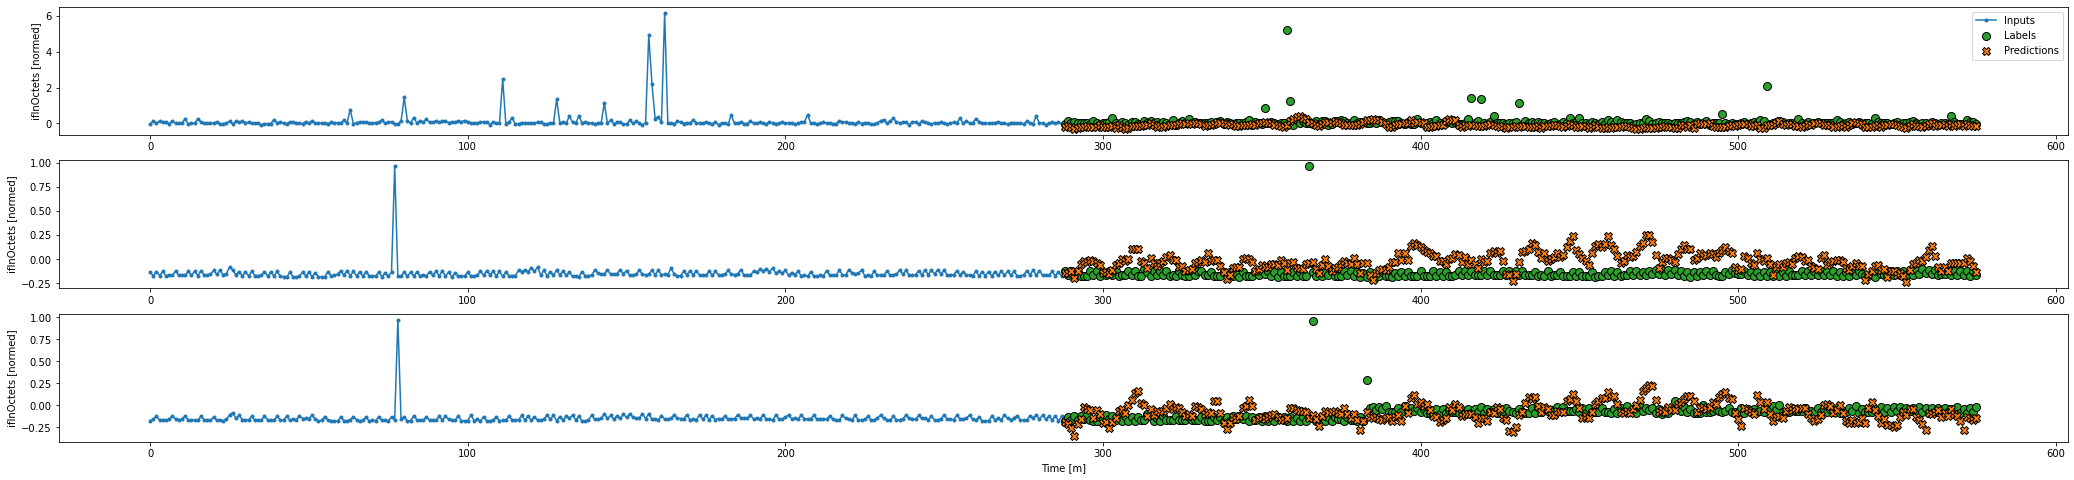

In [283]:
CONV_WIDTH = 3*12
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# RNN

1/1 [==============================] - 0s 93ms/step - loss: 0.1310 - mean_absolute_error: 0.1864


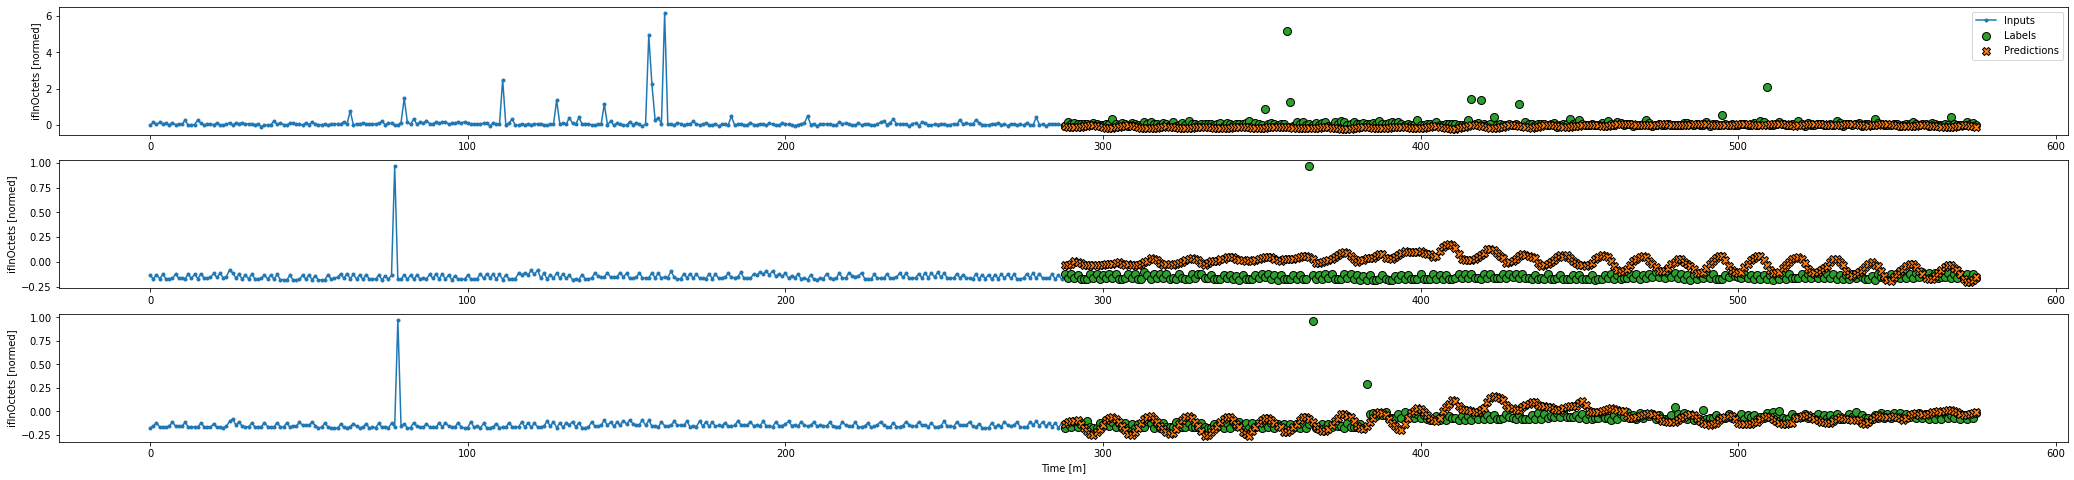

In [284]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Modelo autorregressivo
Todos os modelos acima prevêem toda a sequência de saída em uma única etapa.

Em alguns casos, pode ser útil para o modelo decompor essa previsão em etapas de tempo individuais. Em seguida, a saída de cada modelo pode ser realimentada em cada etapa e as previsões podem ser feitas condicionadas na etapa anterior, como no clássico Gerando Sequências com Redes Neurais Recorrentes .

# RNN

In [285]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [286]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([128, 9])

In [287]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call


print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (128, 288, 9)


1/1 [==============================] - 0s 130ms/step - loss: 0.5796 - mean_absolute_error: 0.5607


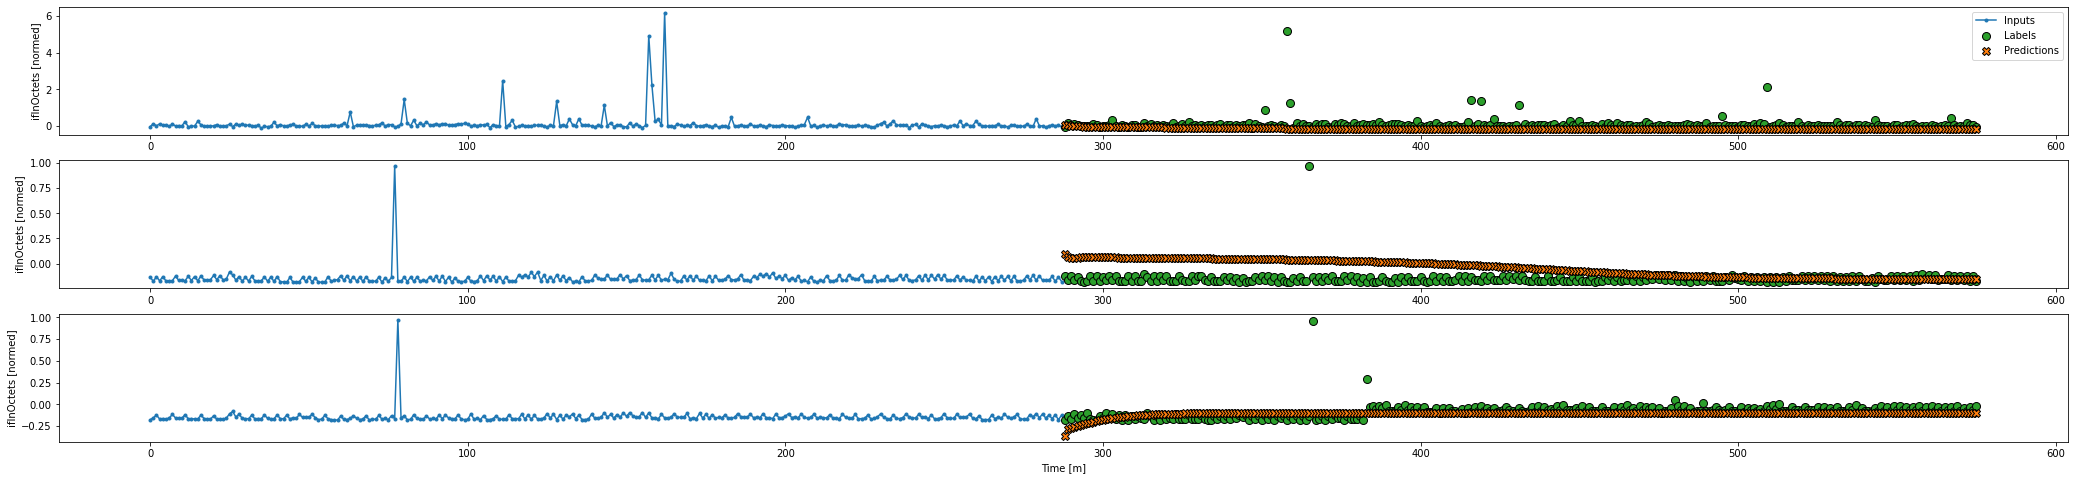

In [288]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Desempenho

In [289]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

IndexError: list index out of range

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')